This is CNN model Generalization code from AI Vietnam AIO2022. Currently, the model has Batch Normalization, Dropout, Kernel regularization, and data augmentation (resize, random crop, flip left-right). The final result is: 

loss: 0.3856 - accuracy: 0.9384 - val_loss: 0.5142 - val_accuracy: 0.9079. The dataset used in this experiment is CIFAR10

From the original code, I want to experiment if the validation accuracy will increase if I add in skip connections, add in 1 more conv2d layer in each block, and use Gelu instead of Relu activation function. The result is:

loss: 0.2940 - accuracy: 0.9775 - val_loss: 0.6456 - val_accuracy: 0.9186

Then, I change the optimizer to NovoGrad, result:

loss: 0.4996 - accuracy: 0.8946 - val_loss: 0.6903 - val_accuracy: 0.8580

Then, I add in glorot weight initializer and change optimizer to adamw, model cannot learn

Then, I change optimizer to radam, model cannot learn either

Then I change optimizer back to adam, now with glorot weight initializer, result is:

loss: 0.2871 - accuracy: 0.9784 - val_loss: 0.6357 - val_accuracy: 0.9177




In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt



(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std  = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean)/(std+1e-7)



In [ ]:
#VGG16 with 1 less conv layer at block 3, 4 and 5, no generalization techniques

inputs = tf.keras.layers.Input(shape=[32, 32, 3])    
x = inputs

# block 1
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# block 2
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# block 3 - removed 1 conv2d layer
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# block 4 - removed 1 conv2d layer
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# block 5 - removed 1 conv2d layer
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)


# FC layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dense(10, activation = 'softmax')(x)


model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 128)       147584    
                                                           

In [ ]:
#training with adam
batch_size = 256
epochs = 100
lr = 0.001

opt_adam  = keras.optimizers.Adam(learning_rate=lr)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_batches = (train_dataset.shuffle(batch_size*4)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/100
196/196 [==============================] - 16s 77ms/step - loss: 1.8908 - accuracy: 0.2637 - val_loss: 1.6032 - val_accuracy: 0.3687
Epoch 2/100
196/196 [==============================] - 15s 77ms/step - loss: 1.3998 - accuracy: 0.4676 - val_loss: 1.2301 - val_accuracy: 0.5537
Epoch 3/100
196/196 [==============================] - 15s 75ms/step - loss: 1.0494 - accuracy: 0.6233 - val_loss: 0.9409 - val_accuracy: 0.6638
Epoch 4/100
196/196 [==============================] - 15s 75ms/step - loss: 0.8478 - accuracy: 0.6992 - val_loss: 0.8496 - val_accuracy: 0.7062
Epoch 5/100
196/196 [==============================] - 15s 75ms/step - loss: 0.6883 - accuracy: 0.7591 - val_loss: 0.8129 - val_accuracy: 0.7286
Epoch 6/100
196/196 [==============================] - 15s 75ms/step - loss: 0.5706 - accuracy: 0.8014 - val_loss: 0.7271 - val_accuracy: 0.7678
Epoch 7/100
196/196 [==============================] - 15s 75ms/step - loss: 0.4815 - accuracy: 0.8328 - val_loss: 0.7762 - val_ac

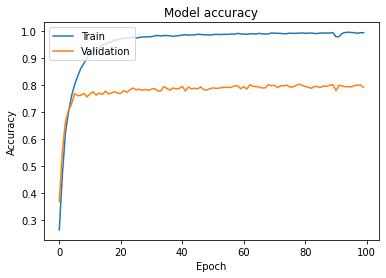

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

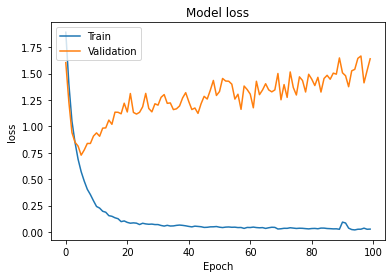

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()